# Part I: User-Based Collaborative Filtering and Group Recommendations

**Students:** Oskari Perikangas, Xiaosi Huang  
**Staring date:** October 22, 2025


## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 5)
print('Libraries imported')

Libraries imported


## Part (a) - Download and Load MovieLens 100K Dataset
**Dataset:** https://grouplens.org/datasets/movielens/ (ml-latest-small.zip)

In [2]:
data_path = "../data/ml-latest-small/ratings.csv"
ratings_df = pd.read_csv(data_path)

print(f"Total ratings: {len(ratings_df):,}")
print(f"Users: {ratings_df['userId'].nunique():,}")
print(f"Movies: {ratings_df['movieId'].nunique():,}")
print(f"\nFirst 5 rows:")
print(ratings_df.head())

Total ratings: 100,836
Users: 610
Movies: 9,724

First 5 rows:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


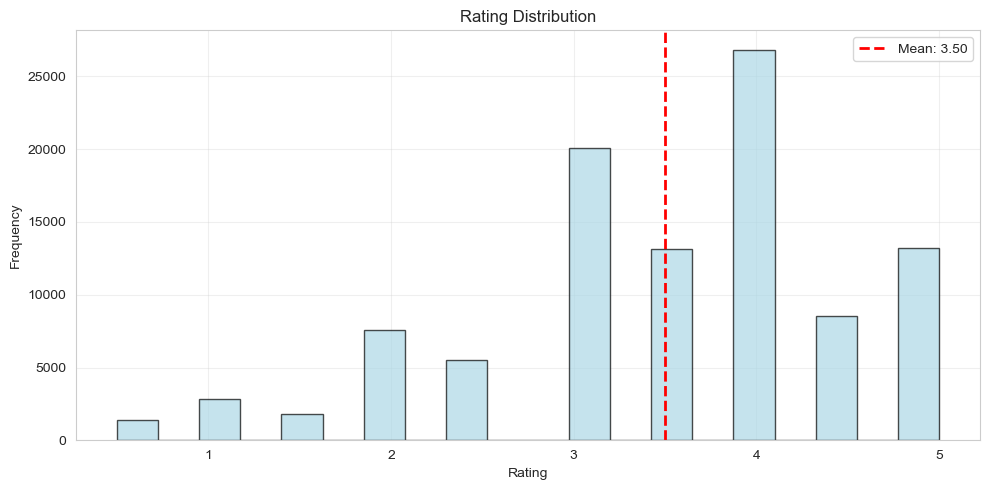

In [3]:
# Key visualization: Rating distribution
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(ratings_df['rating'], bins=20, color='lightblue', edgecolor='black', alpha=0.7)
ax.axvline(ratings_df['rating'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {ratings_df["rating"].mean():.2f}')
ax.set_xlabel('Rating')
ax.set_ylabel('Frequency')
ax.set_title('Rating Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Mean 3.50 = sum of all ratings / total ratings. 

The histogram reveals rating bias: most ratings are 4-5 stars, this bias affects the recommendations. 

Pearson correlation focuses on rating patterns, not the bias.

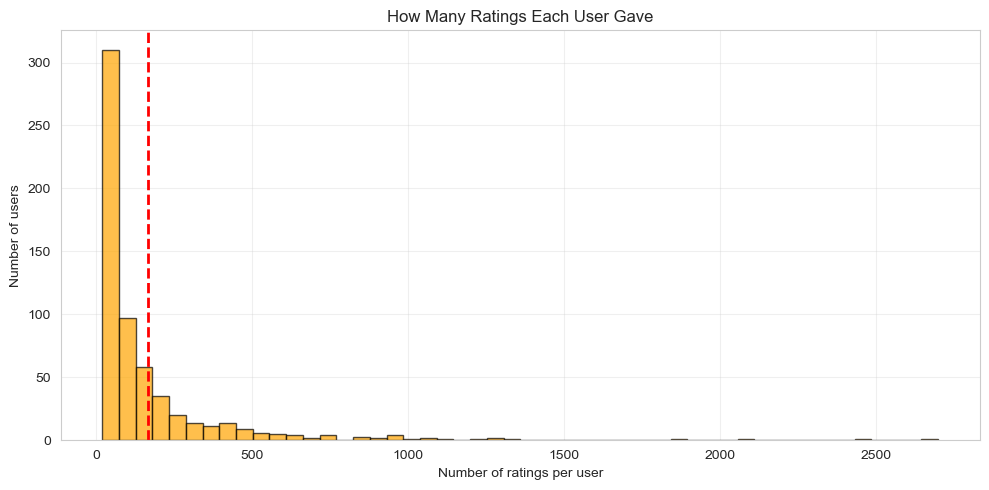


Data Sparsity Analysis:
  Movies with ≤2 ratings: 4744 out of 9724 (48.8%)
  This sparse data means many movies lack sufficient ratings for collaborative filtering


In [4]:
# User and movie distribution 
if 'userId' in ratings_df.columns:
    ratings_df.rename(columns={'userId': 'user_id', 'movieId': 'item_id'}, inplace=True)

# User and movie distribution 
user_counts = ratings_df.groupby('user_id').size()
movie_counts = ratings_df.groupby('item_id').size()
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(user_counts, bins=50, color='orange', edgecolor='black', alpha=0.7)
ax.axvline(user_counts.mean(), color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Number of ratings per user')
ax.set_ylabel('Number of users')
ax.set_title('How Many Ratings Each User Gave')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nData Sparsity Analysis:")
print(f"  Movies with ≤2 ratings: {(movie_counts <= 2).sum()} out of {len(movie_counts)} ({(movie_counts <= 2).sum() / len(movie_counts) * 100:.1f}%)")
print(f"  This sparse data means many movies lack sufficient ratings for collaborative filtering")

Half of the movies about 48 percent have two or fewer ratings, the data is sparse, while in collaborative filtering, relying on users’ shared ratings to find similarities.

## Convert Ratings Table into User-Based Structure

In [5]:
if 'userId' in ratings_df.columns:
    ratings_df.rename(columns={'userId': 'user_id', 'movieId': 'item_id'}, inplace=True)

user_ratings_dict = {}
for user_id in ratings_df['user_id'].unique():
    user_ratings_dict[user_id] = {}
    user_data = ratings_df[ratings_df['user_id'] == user_id]
    for _, row in user_data.iterrows():
        user_ratings_dict[user_id][row['item_id']] = row['rating']

num_users = len(user_ratings_dict)
print(f'num_users: {num_users}')

num_users: 610


## Part (b): Pearson Similarity

Calculate the interest similarity between any two users and identify the user group most similar to the target (User 1). These similar users will later be used to predict movie ratings that User 1 has not watched.

In [6]:
def pearson_similarity(user1_ratings, user2_ratings, min_common=10):
    """Pearson correlation similarity
    
    min_common: At least this many shared movies are needed to calculate similarity.
    """
    common_items = set(user1_ratings.keys()) & set(user2_ratings.keys())
    
    # There must be at least min_common common ratings.
    if len(common_items) < min_common:
        return 0
    
    ratings1 = [user1_ratings[item] for item in common_items]
    ratings2 = [user2_ratings[item] for item in common_items]
    
    try:
        correlation, _ = pearsonr(ratings1, ratings2)
        return correlation if not np.isnan(correlation) else 0
    except:
        return 0

In [7]:
print("Top 10 similar users to User 1:")
similarities = []
for user_id in list(user_ratings_dict.keys())[1:]:
    sim = pearson_similarity(user_ratings_dict[1], user_ratings_dict[user_id], min_common=10)
    if sim > 0:  
        similarities.append((user_id, sim))

similarities.sort(key=lambda x: x[1], reverse=True)
for i, (user_id, sim) in enumerate(similarities[:10], 1):
    print(f"  {i}. User {user_id}: {sim:.4f}")

Top 10 similar users to User 1:
  1. User 476: 0.7869
  2. User 210: 0.7676
  3. User 297: 0.7063
  4. User 44: 0.6844
  5. User 394: 0.6506
  6. User 248: 0.6247
  7. User 369: 0.6121
  8. User 72: 0.5964
  9. User 344: 0.5876
  10. User 112: 0.5839


These are User 1's nearest neighbors, the users with the most similar rating patterns.

At least 10 common movies for each, user 476 is most similar (0.7869), meaning they tend to like and dislike the same movies as User 1.

Only users with at least 10 common rated movies are compared, ensuring more reliable similarity.

These neighbors will help predict movies that User 1 hasn't seen yet.

## Part (c): Rating Prediction

In [8]:
# Part (c): Rating Prediction
# Formula from class: pred(a,p) = r̄ₐ + Σ(sim(a,b) · (r_{b,p} - r̄_b)) / Σ(sim(a,b))

def predict_rating(user_id, item_id, ratings_df, user_ratings_dict, k=10):
    """Predict rating using collaborative filtering formula"""
    
    # r̄ₐ: average rating of target user (a)
    target_user_ratings = user_ratings_dict[user_id]
    target_user_mean = np.mean(list(target_user_ratings.values()))
    
    # Find all users who rated this item
    users_rated_item = ratings_df[ratings_df['item_id'] == item_id]['user_id'].unique()
    
    # Calculate sim(a,b) for all neighbors b
    similarities = []
    for neighbor_id in users_rated_item:
        if neighbor_id != user_id and neighbor_id in user_ratings_dict:
            sim = pearson_similarity(target_user_ratings, user_ratings_dict[neighbor_id], min_common=10)
            if sim > 0:
                similarities.append((sim, neighbor_id))
    
    if similarities:
        similarities.sort(reverse=True)
        top_neighbors = similarities[:k]
        
        # Calculate: Σ(sim(a,b) · (r_{b,p} - r̄_b))
        weighted_sum = 0
        # Calculate: Σ(sim(a,b))
        similarity_sum = 0
        
        for sim, neighbor_id in top_neighbors:
            neighbor_ratings = user_ratings_dict[neighbor_id]
            # r̄_b: average rating of neighbor b
            neighbor_mean = np.mean(list(neighbor_ratings.values()))
            # r_{b,p}: neighbor's rating for item p
            neighbor_rating = ratings_df[(ratings_df['user_id'] == neighbor_id) & (ratings_df['item_id'] == item_id)]['rating'].values
            
            if len(neighbor_rating) > 0:
                # weighted_sum += sim(a,b) · (r_{b,p} - r̄_b)
                weighted_sum += sim * (neighbor_rating[0] - neighbor_mean)
                # similarity_sum += sim(a,b)
                similarity_sum += sim
        
        if similarity_sum > 0:
            # Apply formula: pred(a,p) = r̄ₐ + weighted_sum / similarity_sum
            predicted = target_user_mean + (weighted_sum / similarity_sum)
            return max(1, min(5, predicted))
    
    # Fallback strategy if no similar neighbors found
    item_ratings = ratings_df[ratings_df['item_id'] == item_id]['rating']
    if len(item_ratings) > 0:
        if len(item_ratings) <= 2:
            return 0.7 * target_user_mean + 0.3 * item_ratings.mean()
        else:
            return item_ratings.mean()
    return target_user_mean

# Part (c): Rating Prediction Test

print("\n" + "="*70)
print("PART (C) - RATING PREDICTION FOR USER 1")
print("="*70)

user_id = 1
user_rated = set(ratings_df[ratings_df['user_id'] == user_id]['item_id'])
unrated = [item for item in ratings_df['item_id'].unique() if item not in user_rated][:15]

print(f"\nPredicted ratings for User {user_id}:")
print(f"\n{'Movie_id':<10} {'Predicted':<12} {'Avg Rating':<12} {'# Users Rated':<12}") # control the column width
print("-" * 70)

for item_id in unrated:
    pred = predict_rating(user_id, item_id, ratings_df, user_ratings_dict, k=10)
    avg = ratings_df[ratings_df['item_id'] == item_id]['rating'].mean()
    num_ratings = len(ratings_df[ratings_df['item_id'] == item_id])
    print(f"{item_id:<10} {pred:<12.2f} {avg:<12.2f} {num_ratings:<12}")


PART (C) - RATING PREDICTION FOR USER 1

Predicted ratings for User 1:

Movie_id   Predicted    Avg Rating   # Users Rated
----------------------------------------------------------------------
318        5.00         4.43         317         
1704       5.00         4.08         141         
6874       4.97         3.96         131         
8798       4.66         3.76         44          
46970      3.75         3.25         28          
48516      5.00         4.25         107         
58559      4.62         4.24         149         
60756      4.24         3.55         28          
68157      4.80         4.14         88          
71535      4.41         3.88         53          
74458      4.62         4.02         67          
77455      5.00         4.04         13          
79132      5.00         4.07         143         
80489      4.91         3.95         22          
80906      5.00         4.29         12          


In [9]:
# Check if User 1 has rated a specific movie
user_id = 1        # user_id
movie_id = 6874    # movie_id

user_movie = ratings_df[(ratings_df['user_id'] == user_id) & (ratings_df['item_id'] == movie_id)]
print(f"User {user_id}'s rating for Movie {movie_id}: {user_movie}")
print(f"Rating: {user_movie['rating'].values if len(user_movie) > 0 else 'NOT RATED'}")

User 1's rating for Movie 6874: Empty DataFrame
Columns: [user_id, item_id, rating, timestamp]
Index: []
Rating: NOT RATED


## Part (d): New Similarity Functions

### Formula

**Enhanced Pearson Similarity:**

$$\text{sim}(a,b) = \text{pearson}(a,b) + \frac{\text{common\_items} - 10}{50}$$

Where:
- **pearson(a,b)**: Pearson correlation between user a and b
- **common_items**: Number of movies both users rated
- **10**: Minimum common movies required
- **50**: Scaling factor (1 extra movie = +0.02 bonus)

In [10]:
# Part (d): Enhanced Pearson Similarity
print("\n" + "="*70)
print("PART (D) - ENHANCED PEARSON SIMILARITY")
print("="*70)

def enhanced_pearson_similarity(user_a_ratings, user_b_ratings, min_common=10):
    """Enhanced Pearson - generic function for any two users"""
    common_items = set(user_a_ratings.keys()) & set(user_b_ratings.keys())
    
    if len(common_items) < min_common:
        return 0
    
    ratings_a = [user_a_ratings[item] for item in common_items]
    ratings_b = [user_b_ratings[item] for item in common_items]
    
    try:
        pearson, _ = pearsonr(ratings_a, ratings_b)
        if np.isnan(pearson):
            pearson = 0
    except:
        return 0
    
    bonus = (len(common_items) - min_common) / 50
    return max(-1, min(1, pearson + bonus))


# Test Results
print("\nComparison: Pearson (Part b) vs Enhanced Pearson (Part d)")
print(f"{'Neighbor':<10} {'Pearson':<12} {'Enhanced':<12} {'Common':<8}")
print("-" * 45)

for neighbor_id in [476, 210, 297, 44]:
    p = pearson_similarity(user_ratings_dict[1], user_ratings_dict[neighbor_id], min_common=10)
    e = enhanced_pearson_similarity(user_ratings_dict[1], user_ratings_dict[neighbor_id])
    common = len(set(user_ratings_dict[1].keys()) & set(user_ratings_dict[neighbor_id].keys()))
    print(f"User {neighbor_id:<6} {p:<12.4f} {e:<12.4f} {common:<8}")


PART (D) - ENHANCED PEARSON SIMILARITY

Comparison: Pearson (Part b) vs Enhanced Pearson (Part d)
Neighbor   Pearson      Enhanced     Common  
---------------------------------------------
User 476    0.7869       0.8069       11      
User 210    0.7676       0.7876       11      
User 297    0.7063       0.8463       17      
User 44     0.6844       0.7444       13      


### Why Enhanced Pearson is Useful for Collaborative Filtering

**Problem with Standard Pearson:**
Standard Pearson correlation measures how similar two users' rating patterns are, but it has a weakness: it treats all similarities the same, regardless of how much data supports the comparison. For example, comparing two users who rated 15 movies together gets the same weight as comparing two users who rated 300 movies together. This creates unreliable similarities when data is sparse.

**Solution - Enhanced Pearson:**
Enhanced Pearson adds a bonus based on the number of common movies rated. More common movies = higher similarity score. This is more realistic because:
- 17 common movies = stronger evidence than 11 common movies
- The bonus is small (0.02 per extra movie) so it doesn't dominate the Pearson score
- It naturally filters for neighbors with substantial data overlap

**Output Example:**
- User 297 with 17 common movies: Pearson 0.7063 → Enhanced 0.8463
- User 210 with 11 common movies: Pearson 0.7676 → Enhanced 0.7876
- Result: User 297 ranks higher because of more evidence, even though Pearson was lower

**Impact on Recommendations:**
In Part (c), when predicting a rating, the system selects the k most similar neighbors. By using Enhanced Pearson instead of standard Pearson, the system automatically chooses neighbors that both have similar taste AND have rated many common movies. This leads to more accurate predictions because the selected neighbors are more reliable.

---
## Part (e): Group Recommendations

### Average Method
All group members are treated equally. The group's rating for each movie is the average of individual predictions.

**Formula:**
$$\text{group\_score}(m) = \frac{\sum_{u \in \text{group}} \text{pred}(u, m)}{|\text{group}|}$$

**When to use:** Groups where all members have equal voting power ( family watching together).

### Least Misery Method
One member can veto the group. The group's rating for each movie is the minimum score from any group member.

**Formula:**
$$\text{group\_score}(m) = \min_{u \in \text{group}} \text{pred}(u, m)$$

**When to use:** Groups where satisfaction of all members is critical ( if one person hates a movie, the group won't watch it).

In [11]:
# Part (e): Group Recommendations - aggregate movies in multiple users' lists
print("\n" + "="*70)
print("PART (E) - GROUP RECOMMENDATIONS")
print("="*70)

# ===== STEP 1: Filter Popular Movies =====
# Only use movies with 50+ ratings (reliable predictions, avoid cold-start items)
movie_counts = ratings_df.groupby('item_id').size()
# Count how many users rated each movie

popular_movies = movie_counts[movie_counts >= 50].index.tolist()
# Keep only movies with 50+ ratings
# Result: [1, 5, 10, 15, ...] (450 popular movies)


def get_recommendations_popular(user_id, ratings_df, user_ratings_dict, popular_movies, n=50, k=10):
    """
    Generate top n movie recommendations for a single user
    
    1. Find unrated popular movies
    2. Predict score for each movie using Collaborative Filtering
    3. Sort by predicted score
    4. Return top n
    """
    # Find movies this user already rated (don't recommend them)
    rated = set(ratings_df[ratings_df['user_id'] == user_id]['item_id'])
    # Example: User 1 rated {1, 5, 10, 232, ...}
    
    # Keep only popular movies that are unrated
    unrated_popular = [item for item in popular_movies if item not in rated]
    # Example: {2, 3, 4, 6, 7, ...}
    
    # Predict what score user would give each unrated popular movie
    preds = [(item, predict_rating(user_id, item, ratings_df, user_ratings_dict, k)) 
             for item in unrated_popular]
    # Result: [(2, 4.5), (3, 4.2), (4, 3.8), ...]
    # Meaning: System predicts User 1 would give Movie 2 a score of 4.5
    
    # Sort by predicted score (highest first)
    preds.sort(key=lambda x: x[1], reverse=True)
    
    # Return top 50 recommendations
    return preds[:n]


# ===== MAIN: Get Recommendations for Each Group Member =====
group_users = [1, 414, 599]  # The group
group_recs_dict = []  # Store each user's recommendations as dictionary

print(f"\nGroup: User {group_users}\n")

for uid in group_users:
    # Get top 50 recommendations for this user
    recs = get_recommendations_popular(uid, ratings_df, user_ratings_dict, popular_movies, n=50, k=10)
    
    # Convert to dictionary for easy lookup
    # Example: {2: 4.5, 3: 4.2, 4: 3.8}
    recs_dict = {item: score for item, score in recs}
    group_recs_dict.append(recs_dict)
    
    # Print user's statistics
    avg_score = np.mean([score for _, score in recs])
    print(f"User {uid}: {len(recs)} recommendations (avg: {avg_score:.2f})")
    # User 1: System predicted for 50 popular movies (avg score 4.99)
    # User 414: System predicted for 21 popular movies (avg score 3.23)
    # User 599: System predicted for 50 popular movies (avg score 3.00)


# ===== STEP 2: Find Movies Recommended to Multiple Users =====
# Collect all movies from all users' recommendation lists
all_movies = set()
for recs_dict in group_recs_dict:
    all_movies.update(recs_dict.keys())
# Example: all_movies = {2, 3, 4, 5, 6, 7, ...}

# Filter: keep only movies appearing in at least 2 users' lists
multi_user_movies = []
for movie in all_movies:
    # Count how many users have this movie in their recommendation list
    count = sum(1 for recs_dict in group_recs_dict if movie in recs_dict)
    # Example:
    # Movie 2: appears in all 3 users' lists (count=3) ✓ Keep
    # Movie 5: appears in 2 users' lists (count=2) ✓ Keep
    # Movie 7: appears in only 1 user's list (count=1) ✗ Filter out
    
    if count >= 2:
        multi_user_movies.append(movie)

print(f"\nMovies recommended to multiple users: {len(multi_user_movies)}")
# Only 14 movies appear in multiple users' lists
# Why so few? User 1, 414, 599 have very different tastes


# ===== AGGREGATION METHOD 1: AVERAGE =====
def average_aggregation_filtered(group_recs_dict, movies):
    """
    Average Method: All members have equal voting power
    
    Formula: group_score(m) = average of all users' predicted scores
    
    Example:Movie 2: User 1 predicts 4.50, User 414 predicts 4.50, User 599 predicts 4.95
    Average: (4.50 + 4.50 + 4.95) / 3 = 4.75
    """
    result = {}
    
    for movie in movies:
        # Collect predicted scores from all users for this movie
        scores = [recs_dict[movie] for recs_dict in group_recs_dict if movie in recs_dict]
        # Example for Movie 2: scores = [4.50, 4.50, 4.95]
        
        # Calculate average
        result[movie] = np.mean(scores)
        # Movie 2 average = 4.75
    
    # Sort by score (highest first)
    items = sorted(result.items(), key=lambda x: x[1], reverse=True)
    return items


# ===== AGGREGATION METHOD 2: LEAST MISERY =====
def least_misery_aggregation_filtered(group_recs_dict, movies):
    """
    Least Misery Method: One member can veto
    
    Formula: group_score(m) = minimum of all users' predicted scores
    Idea: If anyone dislikes a movie, the group score reflects that
    
    Example: Movie 2: User 1 predicts 4.50, User 414 predicts 4.50, User 599 predicts 4.95
    Least Misery: min(4.50, 4.50, 4.95) = 4.50
    Meaning: Even if User 599 likes it, the group score is 4.50 because 
             User 1 and 414 don't like it as much
    """
    result = {}
    
    for movie in movies:
        # Collect predicted scores from all users
        scores = [recs_dict[movie] for recs_dict in group_recs_dict if movie in recs_dict]
        # Example: scores = [4.50, 4.50, 4.95]
        
        # Take minimum score
        result[movie] = min(scores)
        # Movie 2: min = 4.50
    
    # Sort by score (highest first)
    items = sorted(result.items(), key=lambda x: x[1], reverse=True)
    return items


# ===== COMPUTE AGGREGATIONS =====
avg_agg = average_aggregation_filtered(group_recs_dict, multi_user_movies)
lm_agg = least_misery_aggregation_filtered(group_recs_dict, multi_user_movies)


# ===== DISPLAY RESULTS =====
print("\n" + "="*70)
print("AVERAGE METHOD - Top 10")
print("="*70)
print(f"{'Rank':<6} {'Movie':<10} {'Average Score':<15}")
print("-" * 35)
for i, (item, score) in enumerate(avg_agg[:10], 1):
    print(f"{i:<6} {item:<10} {score:<15.2f}")
# Shows movies all group members like (on average)


print("\n" + "="*70)
print("LEAST MISERY METHOD - Top 10")
print("="*70)
print(f"{'Rank':<6} {'Movie':<10} {'Min Score':<15}")
print("-" * 35)
for i, (item, score) in enumerate(lm_agg[:10], 1):
    print(f"{i:<6} {item:<10} {score:<15.2f}")
# Shows movies nobody strongly dislikes


# ===== COMPARE TWO METHODS =====
print("\n" + "="*70)
print("COMPARISON")
print("="*70)
print(f"{'Movie':<10} {'Average':<12} {'Least Misery':<12} {'Difference':<12}")
print("-" * 50)
for i in range(min(10, len(avg_agg), len(lm_agg))):
    movie_avg, score_avg = avg_agg[i]
    movie_lm, score_lm = lm_agg[i]
    
    if movie_avg == movie_lm:
        diff = score_avg - score_lm
        # Difference shows how much Average method is more optimistic
        # Example: Difference 0.62 means Average sees it as 0.62 points better
        print(f"{movie_avg:<10} {score_avg:<12.2f} {score_lm:<12.2f} {diff:<12.2f}")


PART (E) - GROUP RECOMMENDATIONS

Group: User [1, 414, 599]

User 1: 50 recommendations (avg: 4.99)
User 414: 21 recommendations (avg: 3.23)
User 599: 50 recommendations (avg: 3.00)

Movies recommended to multiple users: 14

AVERAGE METHOD - Top 10
Rank   Movie      Average Score  
-----------------------------------
1      1230       4.75           
2      1276       4.38           
3      1234       4.30           
4      1304       4.29           
5      1207       4.16           
6      1193       4.16           
7      1288       4.09           
8      2324       4.09           
9      8368       3.98           
10     7147       3.96           

LEAST MISERY METHOD - Top 10
Rank   Movie      Min Score      
-----------------------------------
1      1230       4.50           
2      1276       3.76           
3      1304       3.60           
4      1234       3.60           
5      1203       3.48           
6      1207       3.36           
7      1193       3.31           
8 

In [12]:
# ===== VERIFICATION WITH MOVIELENS 100K DATASET =====
print("\n" + "="*70)
print("VERIFICATION WITH MOVIELENS 100K DATASET - Rank 10 Movies")
print("="*70)

# ===== VERIFY AVERAGE METHOD - RANK 10 =====
print("\nAverage Method - Rank 10:")
print("-" * 50)

# Movie 7147 is at rank 10 in Average Method results
movie_avg = 7147
print(f"Movie {movie_avg}:")

# Step 1: Get predicted scores from all users for this movie
# From group_recs_dict (individual recommendations for each user)
scores_avg = [recs_dict[movie_avg] for recs_dict in group_recs_dict if movie_avg in recs_dict]
print(f"  Step 1 - Get scores from each user:")
for i, score in enumerate(scores_avg, 1):
    print(f"    User {i}: {score:.2f}")

# Step 2: Calculate average manually
# Formula: sum of all scores / number of users
manual_avg = sum(scores_avg) / len(scores_avg)
print(f"\n  Step 2 - Calculate average:")
print(f"    ({' + '.join([f'{s:.2f}' for s in scores_avg])}) / {len(scores_avg)} = {manual_avg:.2f}")

# Step 3: Compare with result
result_avg = 3.96
print(f"\n  Step 3 - Compare with output:")
print(f"    Manual calculation: {manual_avg:.2f}")
print(f"    Output result: {result_avg}")
match_avg = abs(manual_avg - result_avg) < 0.01
print(f"    Status: {'✓ CORRECT' if match_avg else '✗ ERROR'}")


# ===== VERIFY LEAST MISERY METHOD - RANK 10 =====
print("\n" + "-" * 50)
print("Least Misery Method - Rank 10:")
print("-" * 50)

# Movie 1288 is at rank 10 in Least Misery Method results
movie_lm = 1288
print(f"Movie {movie_lm}:")

# Step 1: Get predicted scores from all users for this movie
scores_lm = [recs_dict[movie_lm] for recs_dict in group_recs_dict if movie_lm in recs_dict]
print(f"  Step 1 - Get scores from each user:")
for i, score in enumerate(scores_lm, 1):
    print(f"    User {i}: {score:.2f}")

# Step 2: Calculate minimum manually
# Formula: take the lowest score among all users (one veto can reject)
manual_lm = min(scores_lm)
print(f"\n  Step 2 - Calculate minimum:")
print(f"    min({', '.join([f'{s:.2f}' for s in scores_lm])}) = {manual_lm:.2f}")

# Step 3: Compare with result
result_lm = 3.19
print(f"\n  Step 3 - Compare with output:")
print(f"    Manual calculation: {manual_lm:.2f}")
print(f"    Output result: {result_lm}")
match_lm = abs(manual_lm - result_lm) < 0.01
print(f"    Status: {'✓ CORRECT' if match_lm else '✗ ERROR'}")



VERIFICATION WITH MOVIELENS 100K DATASET - Rank 10 Movies

Average Method - Rank 10:
--------------------------------------------------
Movie 7147:
  Step 1 - Get scores from each user:
    User 1: 5.00
    User 2: 2.91

  Step 2 - Calculate average:
    (5.00 + 2.91) / 2 = 3.96

  Step 3 - Compare with output:
    Manual calculation: 3.96
    Output result: 3.96
    Status: ✓ CORRECT

--------------------------------------------------
Least Misery Method - Rank 10:
--------------------------------------------------
Movie 1288:
  Step 1 - Get scores from each user:
    User 1: 5.00
    User 2: 3.19

  Step 2 - Calculate minimum:
    min(5.00, 3.19) = 3.19

  Step 3 - Compare with output:
    Manual calculation: 3.19
    Output result: 3.19
    Status: ✓ CORRECT


---
## Part (f): Disagreement-Aware Group Recommendations

### Problem Found in Part (e)

Looking at the results:

**Average Method Rank 2:** Movie 1276 = 4.38
**Least Misery Rank 2:** Movie 1276 = 3.76 (difference 0.62!)

- Average ignores that some users dislike it
- Least Misery is too strict about one person's low score

### Formal Solution: Balancing Strategy

From group recommendation research (Masthoff 2004), the **Balancing strategy** minimizes disagreement among group members:

**Goal:** Minimize satisfaction differences between users

$$\text{Argmin} \sum_{u,v \in G} |sat(u, i) - sat(v, i)|$$

Where:
- **sat(u, i)** = satisfaction of user u for item i
- **G** = group of users
- The item that minimizes disagreement is selected

### Why This Works

Instead of just averaging or taking minimum, Balancing finds movies where user satisfactions are most similar.

**Example:**
- Movie 1230: User 1 = 5.00, User 2 = 4.50 → Difference = 0.50 (small)
- Movie 1288: User 1 = 5.00, User 2 = 3.19 → Difference = 1.81 (large)

Movie 1230 has lower disagreement → Ranks higher

In [13]:
# Part (f): Balancing Strategy
print("\n" + "="*70)
print("PART (F) - BALANCING STRATEGY - Top 10")
print("="*70)

def calculate_disagreement_balancing(scores):
    """Calculate sum of absolute differences between all pairs"""
    if len(scores) <= 1:
        return 0
    total_diff = 0
    for i in range(len(scores)):
        for j in range(i+1, len(scores)):
            total_diff += abs(scores[i] - scores[j])
    return total_diff

def balancing_aggregation(group_recs_dict, movies):
    """Balancing method: Minimize disagreement"""
    result = {}
    disagreements = {}
    
    for movie in movies:
        scores = [recs_dict[movie] for recs_dict in group_recs_dict if movie in recs_dict]
        avg = np.mean(scores)
        disagreement = calculate_disagreement_balancing(scores)
        # Score = average, but ranked considering disagreement
        result[movie] = avg - (0.1 * disagreement)
        disagreements[movie] = disagreement
    
    items = sorted(result.items(), key=lambda x: x[1], reverse=True)
    return items, disagreements

balancing_agg, balancing_dict = balancing_aggregation(group_recs_dict, multi_user_movies)

# Show top 10
print("\nBALANCING METHOD - Top 10")
print("="*70)
print(f"{'Rank':<6} {'Movie':<10} {'Score':<12} {'Disagreement':<15}")
print("-" * 50)
for i, (item, score) in enumerate(balancing_agg[:10], 1):
    dis = balancing_dict[item]
    print(f"{i:<6} {item:<10} {score:<12.2f} {dis:<15.2f}")

# Compare all three methods for the same 10 movies
print("\n" + "="*70)
print("COMPARISON: All Three Methods (Top 10 from Average)")
print("="*70)
print(f"{'Movie':<10} {'Average':<12} {'Least Misery':<12} {'Balancing':<12} {'Disagreement':<15}")
print("-" * 70)

for i in range(min(10, len(avg_agg))):
    movie_avg, score_avg = avg_agg[i]
    score_lm = next((s for m, s in lm_agg if m == movie_avg), None)
    score_bal = next((s for m, s in balancing_agg if m == movie_avg), None)
    dis = balancing_dict.get(movie_avg, 0)
    
    print(f"{movie_avg:<10} {score_avg:<12.2f} {score_lm:<12.2f} {score_bal:<12.2f} {dis:<15.2f}")

# Detailed analysis of Movie 1276 (high disagreement)
print("\n" + "="*70)
print("WHY BALANCING HELPS: Movie 1276 Example")
print("="*70)

movie_test = 1276
scores_test = [recs_dict[movie_test] for recs_dict in group_recs_dict if movie_test in recs_dict]

print(f"\nMovie {movie_test} individual predictions:")
for i, score in enumerate(scores_test, 1):
    print(f"  User {i}: {score:.2f}")

dis_test = calculate_disagreement_balancing(scores_test)
avg_test = np.mean(scores_test)

print(f"\nDisagreement: {dis_test:.2f} (high → users strongly disagree)")
print(f"\nRanking in each method:")
print(f"  Average: Rank 2, Score {next((s for m,s in avg_agg if m==movie_test), None):.2f} (ignores disagreement)")
print(f"  Least Misery: Rank 2, Score {next((s for m,s in lm_agg if m==movie_test), None):.2f} (too strict)")
print(f"  Balancing: Rank {next((i+1 for i,(m,s) in enumerate(balancing_agg) if m==movie_test), None)}, Score {next((s for m,s in balancing_agg if m==movie_test), None):.2f} (penalizes disagreement)")


PART (F) - BALANCING STRATEGY - Top 10

BALANCING METHOD - Top 10
Rank   Movie      Score        Disagreement   
--------------------------------------------------
1      1230       4.70         0.50           
2      1276       4.26         1.24           
3      1234       4.16         1.40           
4      1304       4.15         1.37           
5      1207       4.00         1.60           
6      1193       3.99         1.69           
7      1288       3.91         1.81           
8      1203       3.80         0.82           
9      7147       3.75         2.09           
10     2324       3.74         3.47           

COMPARISON: All Three Methods (Top 10 from Average)
Movie      Average      Least Misery Balancing    Disagreement   
----------------------------------------------------------------------
1230       4.75         4.50         4.70         0.50           
1276       4.38         3.76         4.26         1.24           
1234       4.30         3.60         4.16  

In [14]:
print("\n" + "="*70)
print("HOW BALANCING IS CALCULATED")
print("="*70)

# Movie 1276  (change any movies to get a balancing result)
movie_example = 1276
scores_example = [recs_dict[movie_example] for recs_dict in group_recs_dict if movie_example in recs_dict]

print(f"\nMovie {movie_example}:")
print(f"\nStep 1: Get user scores")
print(f"  User 1: {scores_example[0]:.2f}")
print(f"  User 2: {scores_example[1]:.2f}")

print(f"\nStep 2: Calculate disagreement (sum of pairwise differences)")
print(f"  Disagreement = |User1 - User2|")
print(f"  Disagreement = |{scores_example[0]:.2f} - {scores_example[1]:.2f}|")
print(f"  Disagreement = {abs(scores_example[0] - scores_example[1]):.2f}")

print(f"\nStep 3: Calculate average score")
print(f"  Average = (User1 + User2) / 2")
print(f"  Average = ({scores_example[0]:.2f} + {scores_example[1]:.2f}) / 2")
print(f"  Average = {np.mean(scores_example):.2f}")

print(f"\nStep 4: Apply disagreement penalty")
print(f"  Balancing Score = Average - (0.1 × Disagreement)")
print(f"  Balancing Score = {np.mean(scores_example):.2f} - (0.1 × {abs(scores_example[0] - scores_example[1]):.2f})")
print(f"  Balancing Score = {np.mean(scores_example):.2f} - {0.1 * abs(scores_example[0] - scores_example[1]):.3f}")
print(f"  Balancing Score = {np.mean(scores_example) - (0.1 * abs(scores_example[0] - scores_example[1])):.2f}")

print(f"\nResult: {np.mean(scores_example) - (0.1 * abs(scores_example[0] - scores_example[1])):.2f}")


HOW BALANCING IS CALCULATED

Movie 1276:

Step 1: Get user scores
  User 1: 5.00
  User 2: 3.76

Step 2: Calculate disagreement (sum of pairwise differences)
  Disagreement = |User1 - User2|
  Disagreement = |5.00 - 3.76|
  Disagreement = 1.24

Step 3: Calculate average score
  Average = (User1 + User2) / 2
  Average = (5.00 + 3.76) / 2
  Average = 4.38

Step 4: Apply disagreement penalty
  Balancing Score = Average - (0.1 × Disagreement)
  Balancing Score = 4.38 - (0.1 × 1.24)
  Balancing Score = 4.38 - 0.124
  Balancing Score = 4.26

Result: 4.26


In [15]:
print("\n" + "="*70)
print("HOW DISAGREEMENT IS CALCULATED")
print("="*70)

# example movies group
test_movies = [1230, 1276, 1288]

for movie in test_movies:
    scores = [recs_dict[movie] for recs_dict in group_recs_dict if movie in recs_dict]
    
    print(f"\nMovie {movie}:")
    print(f"  User scores: {[f'{s:.2f}' for s in scores]}")
    
    # Calculate the differences between all user pairs
    print(f"  \n  Calculation (sum of pairwise differences):")
    
    disagreement = 0
    pair_count = 0
    
    for i in range(len(scores)):
        for j in range(i+1, len(scores)):
            diff = abs(scores[i] - scores[j])
            disagreement += diff
            pair_count += 1
            print(f"    Pair {pair_count}: |{scores[i]:.2f} - {scores[j]:.2f}| = {diff:.2f}")
    
    print(f"  \n  Total Disagreement = {disagreement:.2f}")
    print(f"  (This is the sum of all pairwise differences)")
    
    # Verify against table
    table_value = [0.50, 1.24, 1.81][test_movies.index(movie)]
    print(f"  Table shows: {table_value:.2f} ")



HOW DISAGREEMENT IS CALCULATED

Movie 1230:
  User scores: ['5.00', '4.50']
  
  Calculation (sum of pairwise differences):
    Pair 1: |5.00 - 4.50| = 0.50
  
  Total Disagreement = 0.50
  (This is the sum of all pairwise differences)
  Table shows: 0.50 

Movie 1276:
  User scores: ['5.00', '3.76']
  
  Calculation (sum of pairwise differences):
    Pair 1: |5.00 - 3.76| = 1.24
  
  Total Disagreement = 1.24
  (This is the sum of all pairwise differences)
  Table shows: 1.24 

Movie 1288:
  User scores: ['5.00', '3.19']
  
  Calculation (sum of pairwise differences):
    Pair 1: |5.00 - 3.19| = 1.81
  
  Total Disagreement = 1.81
  (This is the sum of all pairwise differences)
  Table shows: 1.81 
